# CWM1-Steinschlagrisiko
<p>Datum: 13.01.2023</p>
<p>Autoren: Logan Henchoz, Noah Recher, Kevin Wartmann, Arian Iseni</p>

##### HINWEIS: Notizbuch mit Jupyter Notebook öffnen



<a id='Inhalt'></a>
## I. Inhaltsverzeichnis
[1. Einleitung](#1)<br>
[2. Systemdefinition](#2)<br>
$\;\;\;\;$ [2.1 Daten](#2.1)<br>
$\;\;\;\;$ [2.2 Zufallsvariablen](#2.2)<br>
[3. Lösungsstrategie](#3)<br>
$\;\;\;\;$ [3.1 Explorative Datenanalyse](#3.1)<br>
$\;\;\;\;$ [3.2 Verteilungsfunktionen bestimmen](#3.2)<br>
[4. Wahrscheinlichkeitsmodell](#4)<br>
$\;\;\;\;$ [4.1 Monte Carlo Simulation](#4.1)<br>
$\;\;\;\;$ [4.2 Simulierte Zufallsvariablen zusammenfügen](#4.2)<br>
$\;\;\;\;$ [4.3 Berechnung der Netzdurchbrüche](#4.3)<br>
$\;\;\;\;$ [4.4 Berechnung des Verkehrs](#4.4)<br>
[5. Ergebnisse](#5)<br>
$\;\;\;\;$ [5.1 Berechnung der Steinschläge](#5.1)<br>
$\;\;\;\;$ [5.2 Berechnung des Verkehrs](#5.2)<br>
$\;\;\;\;$ [5.3 Finale Berechnungen](#5.3)<br>

<a id='1'></a>
## 1. Einleitung
Dieses Skript wurde für die CWM1 Challenge - "Steinschlagrisiko" erstellt und benötigt deren Datensätze um zu funktionieren.
Unsere Aufgabe war es, zu beweisen, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 0.0001 ist. Und abschliessend, aus unseren berechneten Wahrscheinlichkeiten, eine Empfehlung an den Kantonsingenieur zu geben.
Um diese Fragestellung zu beantworten wurden und zwei Datensetzte zur Verfügung gestellt, sowie diverse Informationen zu Verkehr und den Sicherheitsnetzen.

[↑Inhaltsverzeichnis↑](#Inhalt)
<a id='2'></a>
## 2. Systemdefinition

<a id='2.1'></a>
### 2.1 Daten
#### 2.1.1 Quellen
Die Daten für die Analyse beziehen wir von den Webseiten: [Ereignis aus Ablösungszone 1](https://www.dropbox.com/s/i58gdv6pzi03rhr/out_1.csv?dl=0) und [Ereignis aus Ablösungszone 2](https://www.dropbox.com/s/3nk9pv7nzz8f0qb/out_2.csv?dl=0).
Aus der [Aufgabenstellung](https://spaces.technik.fhnw.ch/spaces/steinschlagrisiko#:~:text=vor%203%20Monaten.-,Aufgabenstellung,-Die%20Kantonsstrasse%20unterhalb) und den [Grundlagen](https://spaces.technik.fhnw.ch/spaces/steinschlagrisiko#:~:text=13.%20Januar%202023-,Grundlagen,-F%C3%BCr%20die%20Planung) bekommen wir folgende Informationen:
- Damit die Strasse offen bleibt, braucht es eine Wahrscheinlichkeit von unter 0.0001.
- Die Geschwindigkeit ist durch einen Radar aufgenommen und sehr präzise.
- Die Masse ist eine Experten-Schätzung des Geologen.
- Ein beauftragtes Ingenieurbüro hat geschätzt, dass die Sicherheitsnetze bis zu einer Aufprallenergie von 1000 kJ sicher sind.
- Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ.
- Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).
- Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor.
- Das Tempolimit beträgt 60 km/h.

#### 2.1.2 Datensätze
Für die Analyse verwenden wir zwei Datensätze, beide sind gleich strukturiert. Jediglich die Spaltennamen sind leicht anders.
Beide Datensätze beinhalten folgende Informationen:

| Spaltenname Zone 1  | Spaltenname Zone 2 | Beschreibung                                            |
|:--------------------|:-------------------|:--------------------------------------------------------|
| Datum | Date               | Datum an welchem der Stein gefallen ist                 |
| Uhrzeit  | Uhrzeit            | Uhrzeit an welcher der Stein gefallen ist               |
| Masse [kg] | m [kg]             | Masse vom Stein in Kilogramm (Experten-Schätzung)       |
| Geschwindigkeit [m/s] | v [m/s] | Fallgeschwindigkeit des Steines (von Radar aufgenommen) |

[↑Inhaltsverzeichnis↑](#Inhalt)
<a id='2.2'></a>
### 2.2 Zufallsvariablen
Für unsere Analyse möchten wir folgende Zufallsvariablen untersuchen:

| Zufallsvariable     |                                    Beschreibung |
|:--------------------|:------------------------------------------------|
| Time_delta_(h) | Zeit (in Stunden), welche seit dem letztem Steinschlag vergangen ist|
| Mass_(kg)  | Masse vom Stein in Kilogramm|
| Velocity_(m/s) | Fallgeschwindigkeit des Steines|
<u>Anmerkung:</u>
Die Zufallsvariablen werden wir für beide Datensätze separat berechnen müssen, da es sich um zwei unterschiedliche Ablösezonen handelt mit unterschiedlichen Eigenschaften.
Die Aufprallenergie wird nicht als Zufallsvariable angesehen, da sie abhängig von der Fallgeschwindigkeit und der Masse der Steine ist.


<a id='3'></a>
## 3. Lösungsstrategie
Unsere Lösungsansatz lässt sich in folgende Abschnitte gliedern:





<a id='3.1'></a>
### 3.1 Explorative Datenanalyse
<a id='explorativedatenanalyse'></a>

#### Module importieren

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import sys
from datetime import datetime

#### Daten laden und säubern

In [2]:
def open_csv_to_df(directory):

    # CSV-Datei einlesen
    df = pd.read_csv(directory)

    # Spalten befüllen und neu beschriften
    df = df.iloc[0:,:4]
    df.columns = ["Date", "Time", "Mass_(kg)", "Velocity_(m/s)"]

    # Nach Datum sortieren
    df = df.sort_values(['Date', 'Time']).reset_index(drop=True)

    # NAs löschen
    df = df.dropna()

    # Datum und Zeit in einer Spalte zusammenfügen
    df["Date"] = pd.to_datetime(df.Date.astype(str) + " " +  df.Time.astype(str), format = '%Y-%m-%d %H:%M')

    # Zeit-Spalten bereinigen
    df.rename(columns = {'Date':'Datetime'}, inplace=True)

    return df

In [3]:
df_area1 = open_csv_to_df("./out_1.csv")
df_area1

,Datetime,Time,Mass_(kg),Velocity_(m/s)
0,2019-01-01 09:00:00,09:00,194.0,8.4
1,2019-01-01 21:00:00,21:00,224.0,8.8
2,2019-01-02 14:00:00,14:00,3104.0,9.2
3,2019-01-04 15:00:00,15:00,228.0,8.0
4,2019-01-05 23:00:00,23:00,755.0,7.0
...,...,...,...,...
63,2019-03-18 16:00:00,16:00,167.0,8.9
64,2019-03-22 18:00:00,18:00,2847.0,7.0
65,2019-03-26 00:00:00,00:00,44.0,8.9
66,2019-03-26 06:00:00,06:00,45.0,8.4


In [4]:
df_area2 = open_csv_to_df("./out_2.csv")
df_area2

,Datetime,Time,Mass_(kg),Velocity_(m/s)
0,2019-01-01 09:00:00,09:00,38.0,45.4
1,2019-01-03 06:00:00,06:00,187.0,41.6
2,2019-01-04 10:00:00,10:00,36.0,44.6
3,2019-01-07 14:00:00,14:00,6.0,41.2
4,2019-01-11 06:00:00,06:00,65.0,39.6
5,2019-01-11 16:00:00,16:00,58.0,33.2
6,2019-01-14 11:00:00,11:00,365.0,40.2
7,2019-01-16 02:00:00,02:00,22.0,46.5
8,2019-01-18 06:00:00,06:00,146.0,36.2
9,2019-01-19 17:00:00,17:00,29.0,38.3


#### Zeitabstände berechnen

In [5]:
def calc_time_delta(df):

    # Neue Spalte erstellen
    df.insert(3, "Time_delta_(h)", "")

    # Zeitabstand berechnen
    for i in range(len(df)-1):
        date1 = df.iloc[i,0]
        date2 = df.iloc[i+1,0]
        time_delta = date2 - date1
        time_delta = (time_delta.days*24) + (time_delta.seconds//3600)
        df.iloc[i+1,3] = time_delta

    # Erster Eintrag mit Null ersetzen
    df.iloc[0,3] = 0

    # Datentyp zu Integer ändern
    df['Time_delta_(h)'] = df['Time_delta_(h)'].astype('int')

    return df

In [6]:
df_area1 = calc_time_delta(df_area1)
df_area1

,Datetime,Time,Mass_(kg),Time_delta_(h),Velocity_(m/s)
0,2019-01-01 09:00:00,09:00,194.0,0,8.4
1,2019-01-01 21:00:00,21:00,224.0,12,8.8
2,2019-01-02 14:00:00,14:00,3104.0,17,9.2
3,2019-01-04 15:00:00,15:00,228.0,49,8.0
4,2019-01-05 23:00:00,23:00,755.0,32,7.0
...,...,...,...,...,...
63,2019-03-18 16:00:00,16:00,167.0,28,8.9
64,2019-03-22 18:00:00,18:00,2847.0,98,7.0
65,2019-03-26 00:00:00,00:00,44.0,78,8.9
66,2019-03-26 06:00:00,06:00,45.0,6,8.4


In [7]:
df_area2 = calc_time_delta(df_area2)
df_area2

,Datetime,Time,Mass_(kg),Time_delta_(h),Velocity_(m/s)
0,2019-01-01 09:00:00,09:00,38.0,0,45.4
1,2019-01-03 06:00:00,06:00,187.0,45,41.6
2,2019-01-04 10:00:00,10:00,36.0,28,44.6
3,2019-01-07 14:00:00,14:00,6.0,76,41.2
4,2019-01-11 06:00:00,06:00,65.0,88,39.6
5,2019-01-11 16:00:00,16:00,58.0,10,33.2
6,2019-01-14 11:00:00,11:00,365.0,67,40.2
7,2019-01-16 02:00:00,02:00,22.0,39,46.5
8,2019-01-18 06:00:00,06:00,146.0,52,36.2
9,2019-01-19 17:00:00,17:00,29.0,35,38.3


#### Deskriptive Statistik

In [8]:
df_area1.describe()

,Mass_(kg),Time_delta_(h),Velocity_(m/s)
count,68.000000,68.000000,68.000000
mean,628.632353,30.102941,8.788235
std,695.884703,27.789260,1.989189
min,12.000000,0.000000,3.600000
25%,214.750000,5.750000,7.300000
50%,402.500000,22.000000,8.800000
75%,773.000000,49.000000,10.125000
max,3104.000000,113.000000,14.100000


In [9]:
df_area2.describe()

,Mass_(kg),Time_delta_(h),Velocity_(m/s)
count,32.000000,32.000000,32.000000
mean,99.250000,64.250000,37.790625
std,104.072555,55.533193,5.395778
min,0.000000,0.000000,24.900000
25%,36.750000,27.750000,33.200000
50%,58.000000,48.500000,38.750000
75%,140.000000,77.250000,41.725000
max,406.000000,212.000000,46.500000


#### Null-Wert in Masse imputieren

In [10]:
# Null-Werte anzeigen
df_area2.loc[df_area2['Mass_(kg)'] == 0]

,Datetime,Time,Mass_(kg),Time_delta_(h),Velocity_(m/s)
23,2019-03-10 16:00:00,16:00,0.0,67,32.3


In [11]:
# Null-Wert löschen
df_area2['Mass_(kg)'] = df_area2['Mass_(kg)'].replace(0, df_area2['Mass_(kg)'].median())

#### Vergleich der beiden Zonen

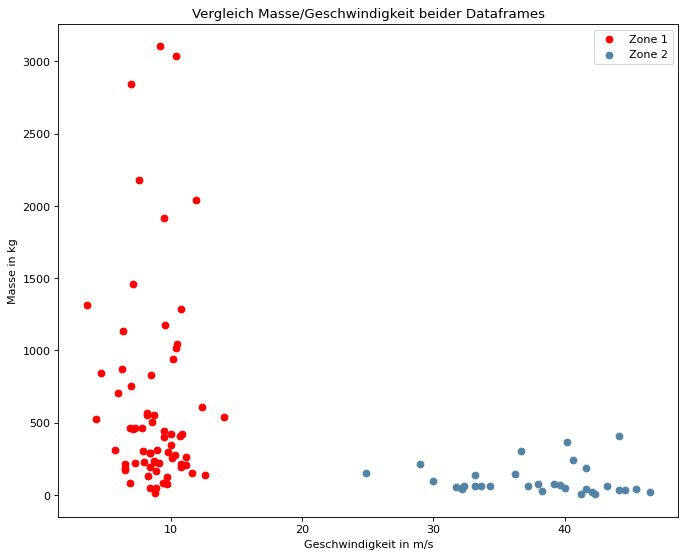

In [12]:
plt.figure(figsize=(10, 8), dpi=80)
plt.title("Vergleich Masse/Geschwindigkeit beider Dataframes")
plt.xlabel("Geschwindigkeit in m/s")
plt.ylabel("Masse in kg")
plt.scatter(x = df_area1["Velocity_(m/s)"],y = df_area1["Mass_(kg)"], color = "red", label = "Zone 1")
plt.scatter(x = df_area2["Velocity_(m/s)"],y = df_area2["Mass_(kg)"], color = '#5384A6', label = "Zone 2")
plt.legend(loc='upper right')
plt.show()

#### Abhängigkeit von Tageszeit und Steinschlag

In [13]:
def plot_incidents_over_time(df, zone):
    df.sort_values(by = "Time", inplace = True)
    plt.hist(df["Time"], color='#5384A6', bins= 20)
    plt.xticks(rotation=90)
    plt.xlabel("Uhrzeit")
    plt.ylabel("Anzahl")
    plt.title("Verteilung der Steinschläge nach Uhrzeit in {}".format(zone))
    plt.show()

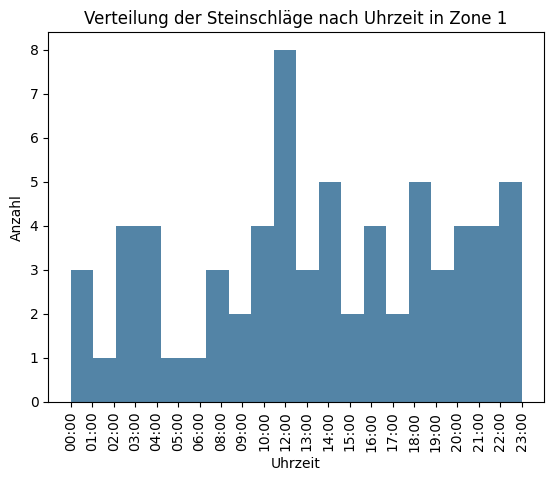

In [14]:
plot_incidents_over_time(df_area1, "Zone 1")

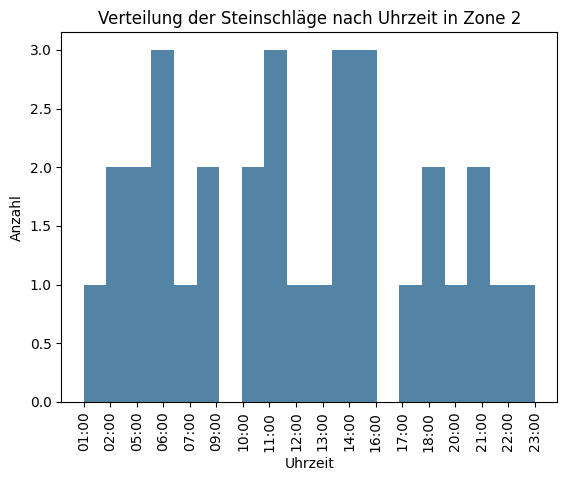

In [15]:
plot_incidents_over_time(df_area2, "Zone 2")

#### Visualisierung der Verteilung von Zufallsvariablen

In [16]:
# Histrogramm erstellen
def plot_histogram(data, zone):
    plt.hist(data, bins = 15, color='#5384A6')
    plt.xlim([data.min(), data.max()])
    plt.xlabel(data.head().name)
    plt.ylabel('Anzahl')
    plt.title('Histrogramm von ' + data.head().name + ' in ' + zone)

##### Zone 1

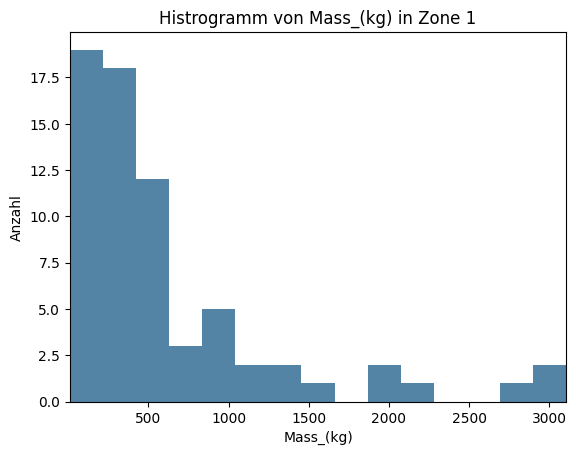

In [17]:
plot_histogram(df_area1["Mass_(kg)"], "Zone 1")

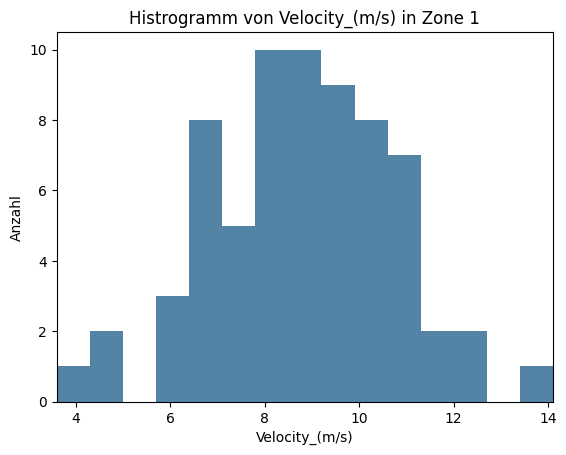

In [18]:
plot_histogram(df_area1["Velocity_(m/s)"], "Zone 1")

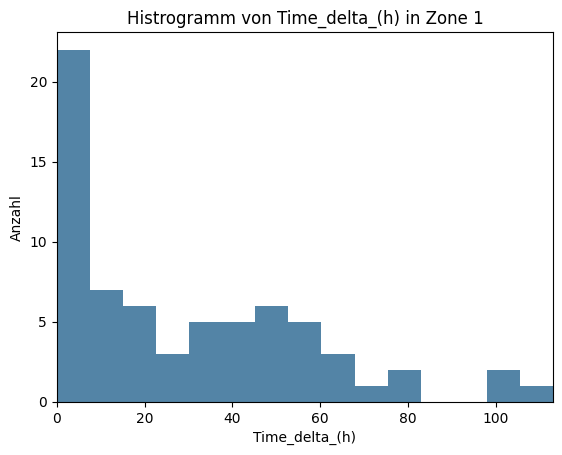

In [19]:
plot_histogram(df_area1["Time_delta_(h)"], "Zone 1")

##### Zone 2

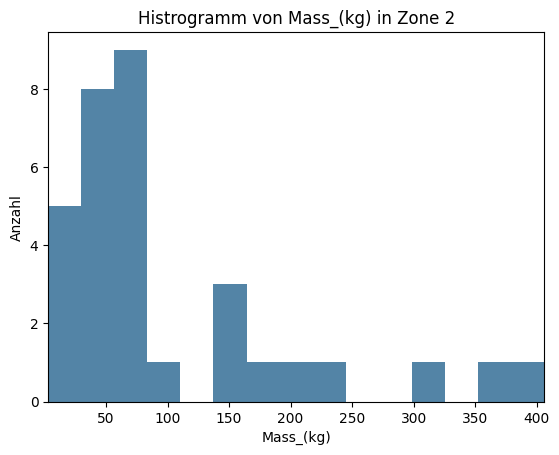

In [20]:
plot_histogram(df_area2["Mass_(kg)"], "Zone 2")

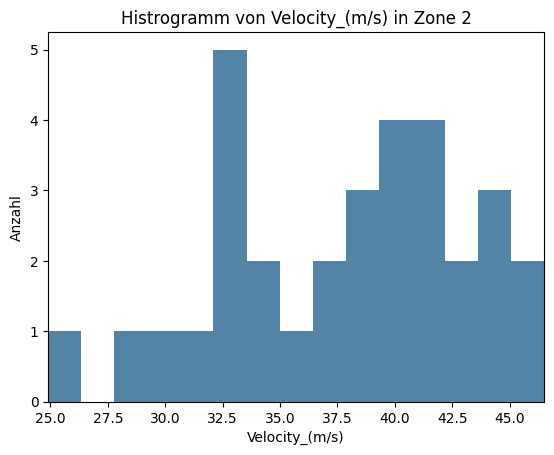

In [21]:
plot_histogram(df_area2["Velocity_(m/s)"], "Zone 2")

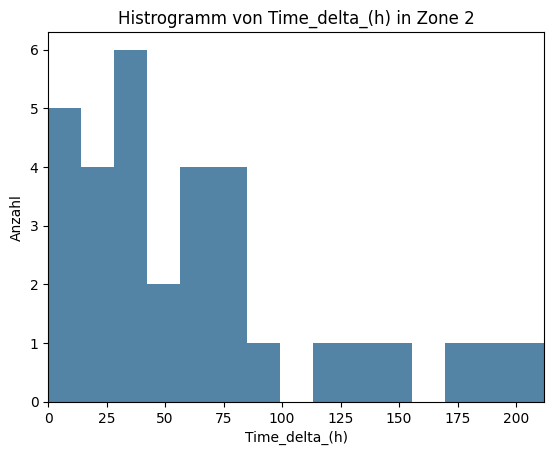

In [22]:
plot_histogram(df_area2["Time_delta_(h)"], "Zone 2")

<a id='3.2'></a>
### 3.2 Verteilungsfunktionen bestimmen

In [23]:
def fit(data):
    # Verteilungsfunktionen welche getestet werden definieren
    distributions = ['norm', 'expon', 'lognorm','gamma', 'cauchy']

    # Werte gleichmässig auf X-Achse verteilen
    x = np.linspace(min(data), max(data), 1_000)

    # CDF von den definierten Verteilungsfunktionen erstellen
    for distribution in distributions:
        param = eval('stats.' + distribution + '.fit(data)')
        sample = eval('stats.' + distribution + '.cdf(x, *param)')
        plt.plot(x, sample)

    # ECDF ploten
    plt.hist(data, cumulative=True, density=True, bins=200, color='#5384A6')
    plt.xlim([data.min(), data.max()])
    plt.xlabel(data.head().name)
    plt.ylabel('F(x)')
    plt.legend(distributions, loc='lower right')
    plt.title('Empirische kumulative Verteilungsfunktion von ' + data.head().name)

    # QQ-Plots für die Verteilungsfunktionen erstellen und ploten
    count = 0
    fig, ax = plt.subplots(1, len(distributions), figsize=(25, 5))
    fig.suptitle('Quantil-Quantil Plots der angepassten Verteilungsfunktionen und ' + data.head().name, fontsize=16)

    for distribution in distributions:
        param = eval('stats.' + distribution + '.fit(data)')
        sample = eval('stats.' + distribution + '.rvs(*param, size = 10000)')
        sm.qqplot_2samples(data, sample, xlabel=distribution.capitalize() + ' Verteilung', ylabel='Probe Verteilung', line='45', ax=ax[count])
        count += 1

#### Zone 1
##### Masse

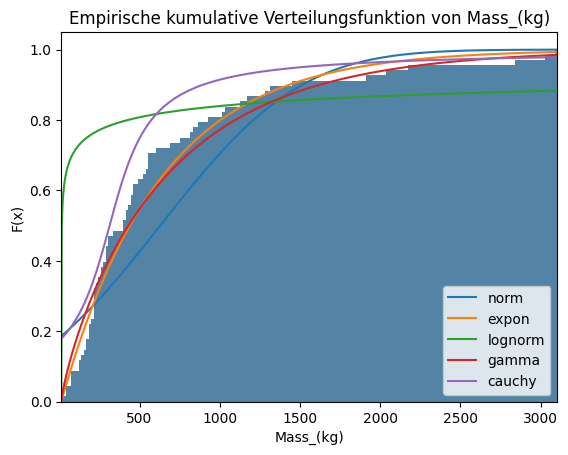

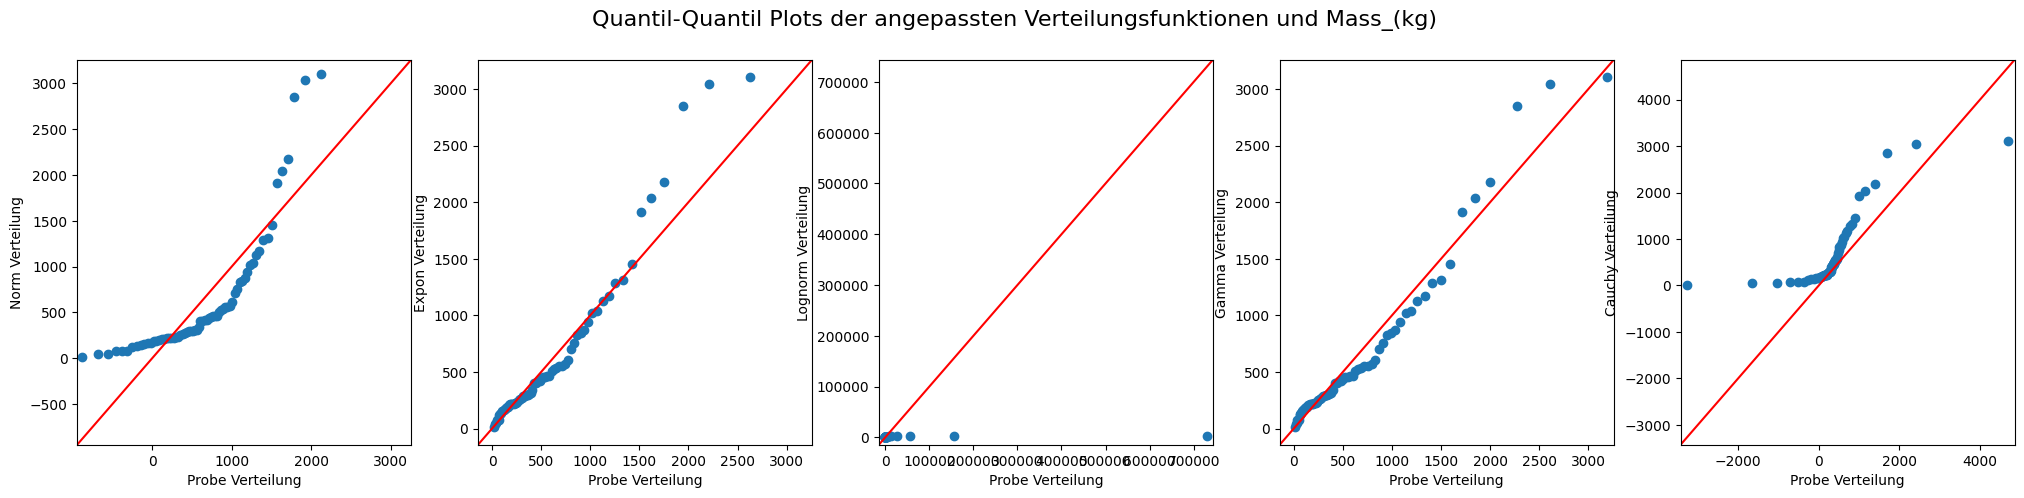

In [24]:
fit(df_area1['Mass_(kg)'])

##### Geschwindigkeit

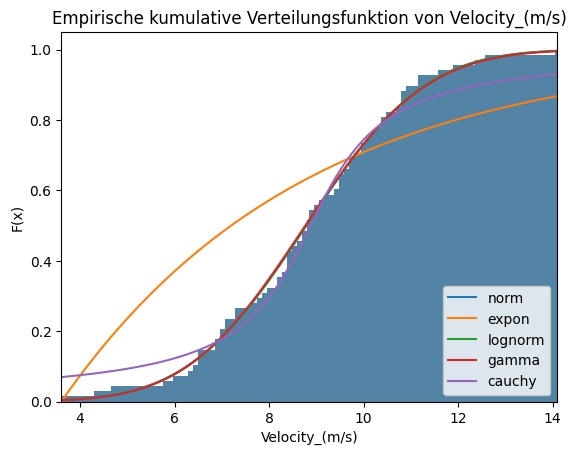

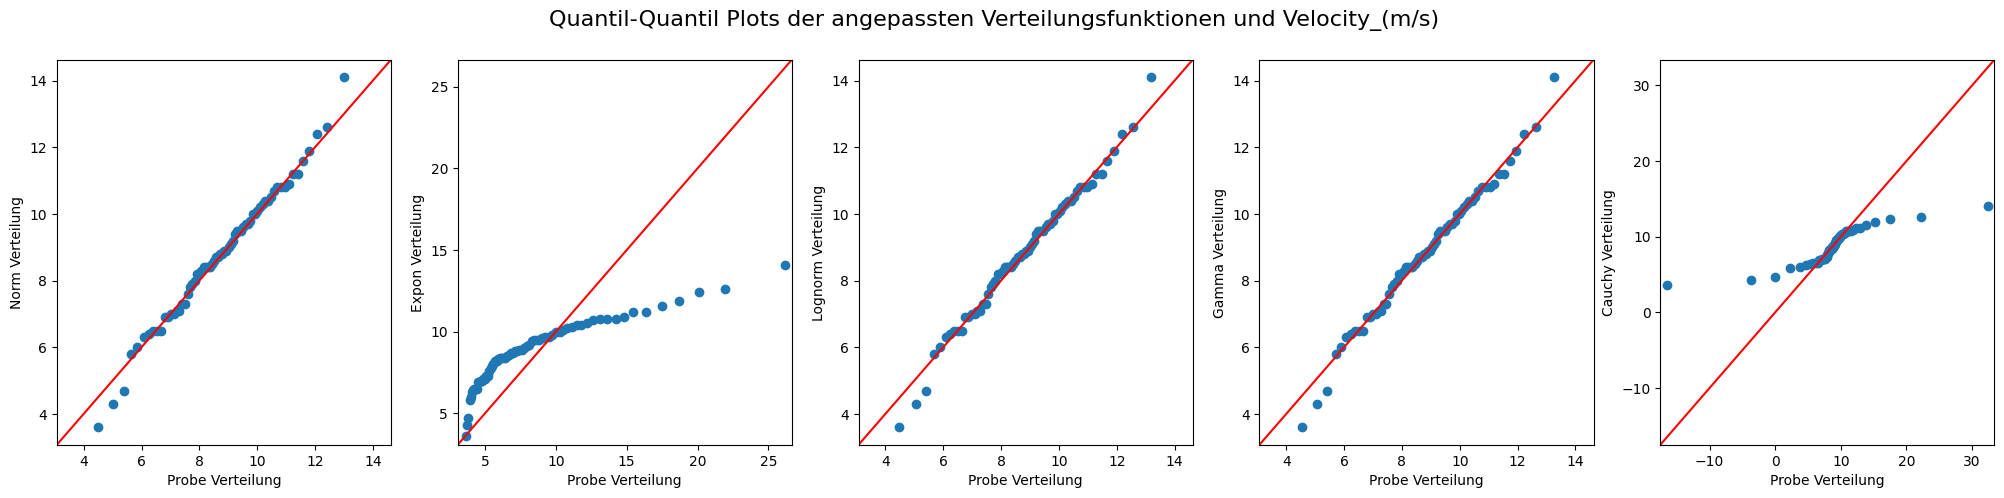

In [25]:
fit(df_area1["Velocity_(m/s)"])

##### Zeitabstand

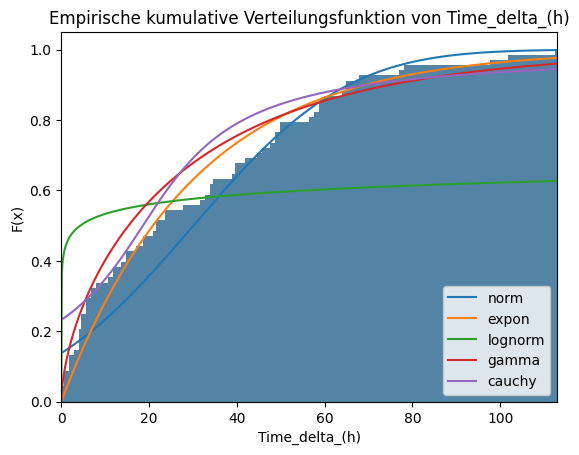

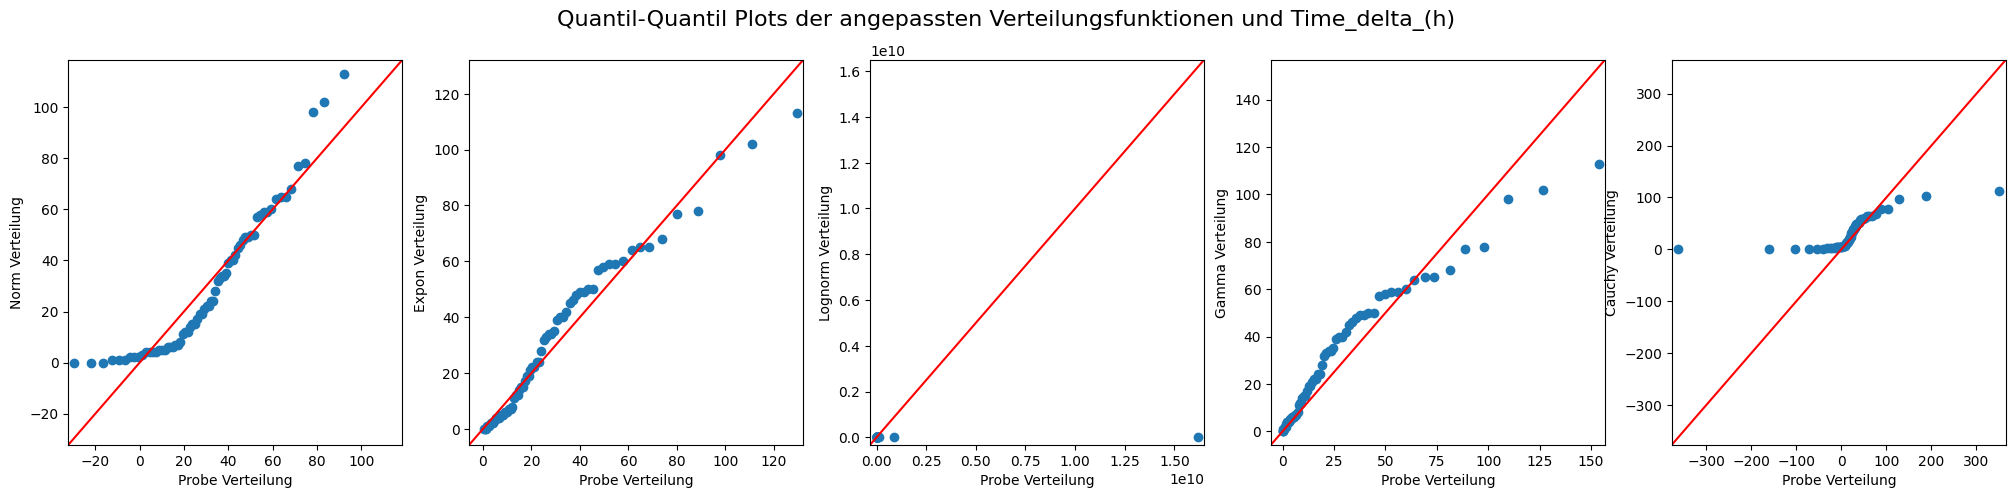

In [26]:
fit(df_area1["Time_delta_(h)"])

#### Zone 2
##### Masse

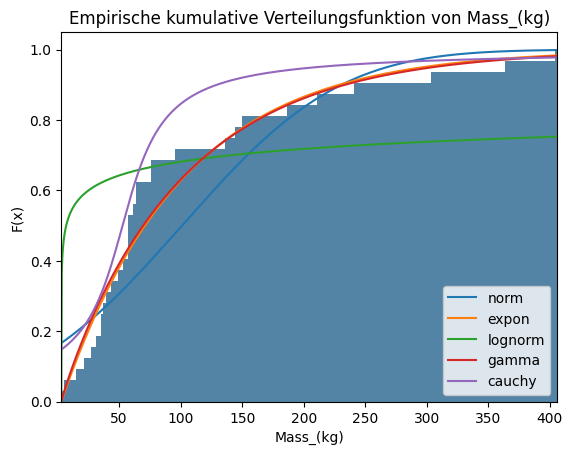

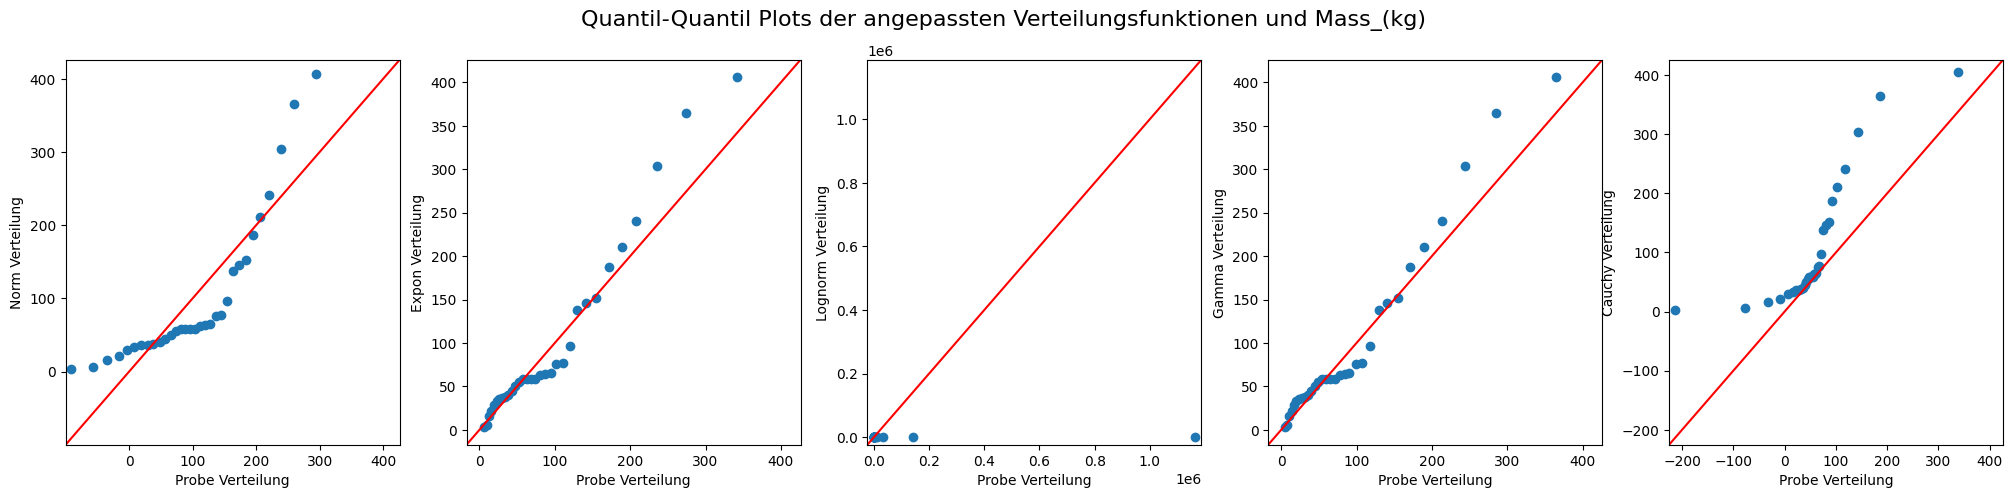

In [27]:
fit(df_area2['Mass_(kg)'])

##### Geschwindigkeit

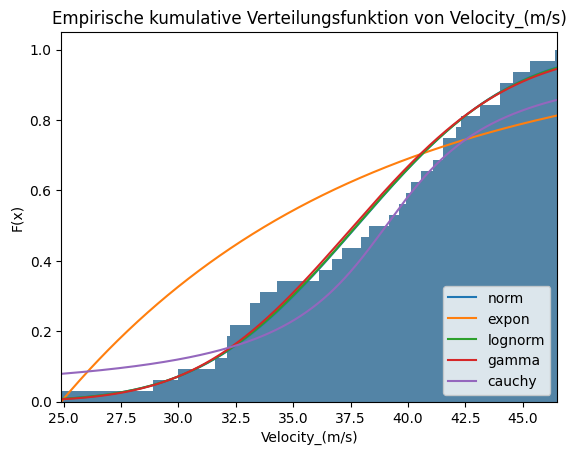

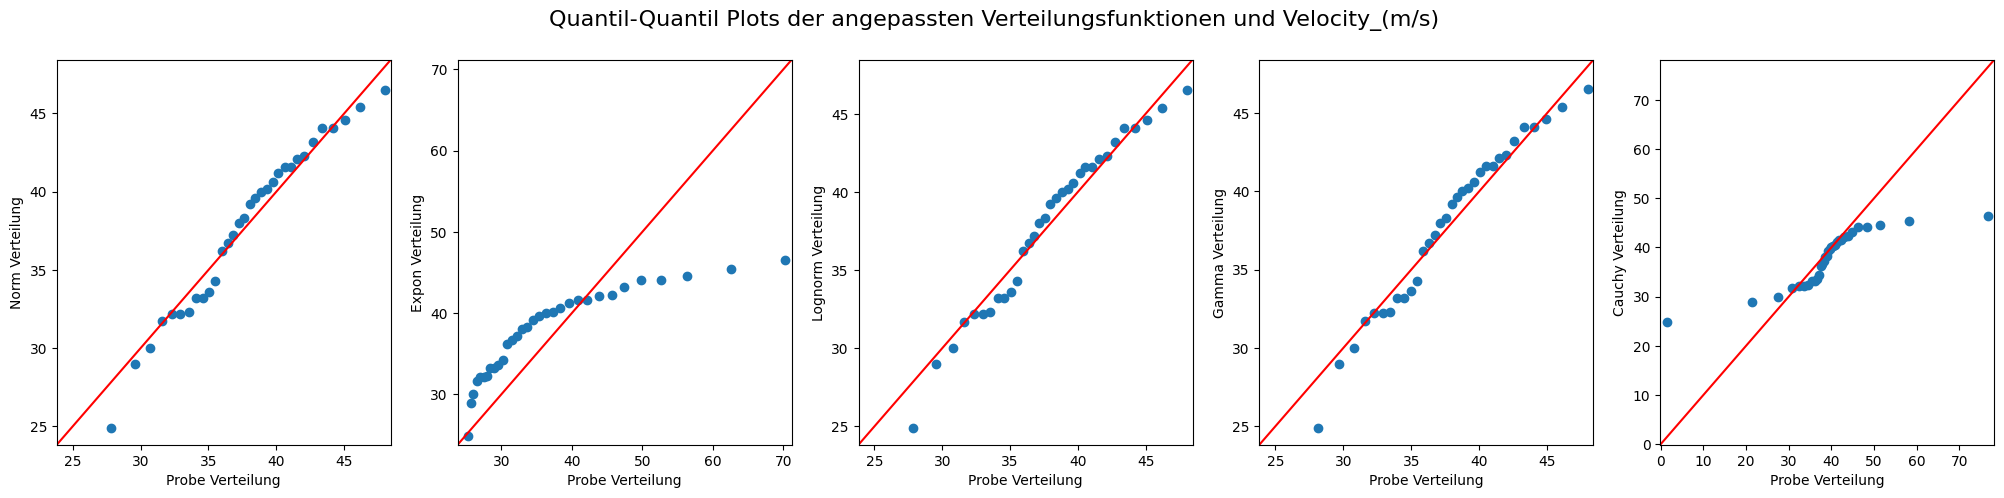

In [28]:
fit(df_area2["Velocity_(m/s)"])

##### Zeitabstand

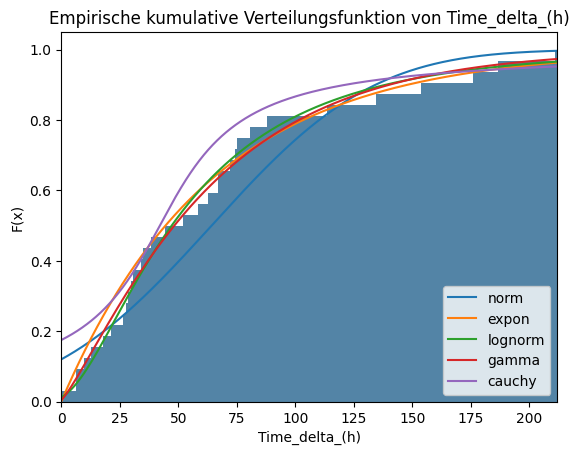

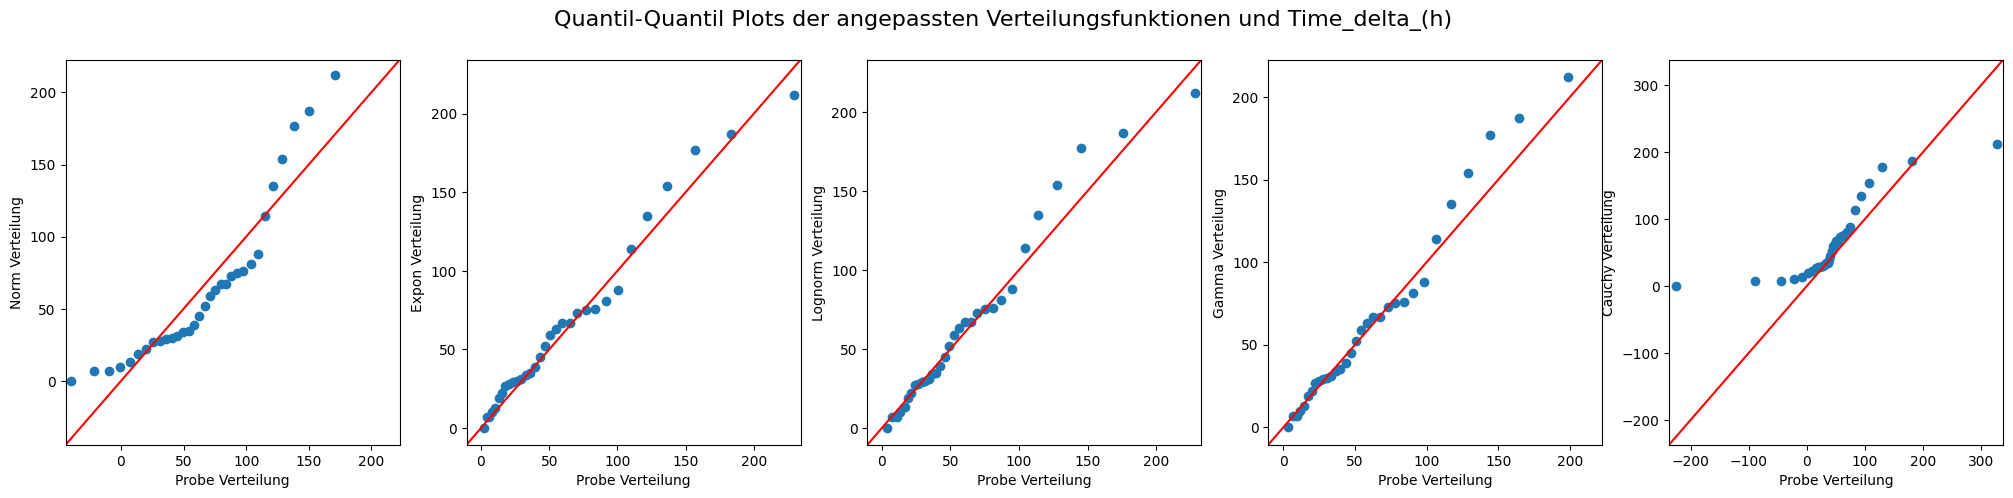

In [29]:
fit(df_area2["Time_delta_(h)"])

[↑Inhaltsverzeichnis↑](#Inhalt)
<a id='4'></a>
## 4. Wahrscheinlichkeitsmodell


<a id='4.1'></a>
### 4.1 Monte Carlo Simulation

In [30]:
# Anzahl Simulationen
sim_count = 108_000

#### Zone 1

In [31]:
# Masse
param = stats.gamma.fit(df_area1['Mass_(kg)'])
zone1_mass = stats.gamma.rvs(*param, size = sim_count)

# Geschwindigkeit
param = stats.norm.fit(df_area1["Velocity_(m/s)"])
zone1_velocity = stats.norm.rvs(*param, size = sim_count)

# Zeitabstand
param = stats.expon.fit(df_area1["Time_delta_(h)"])
zone1_time_delta = stats.expon.rvs(*param, size = sim_count)

#### Zone 2

In [32]:
# Masse
param = stats.gamma.fit(df_area2['Mass_(kg)'])
zone2_mass = stats.gamma.rvs(*param, size = sim_count)

# Geschwindigkeit
param = stats.norm.fit(df_area2["Velocity_(m/s)"])
zone2_velocity = stats.norm.rvs(*param, size = sim_count)

# Zeitabstand
param = stats.expon.fit(df_area2["Time_delta_(h)"])
zone2_time_delta = stats.expon.rvs(*param, size = sim_count)

<a id='4.2'></a>
### 4.2 Simulierte Zufallsvariablen zusammenfügen

#### Zone 1

In [33]:
# Dataframe erstellen
df_area1_sim = pd.DataFrame()

# Simulierte Zufallsvariable einfügen
df_area1_sim.insert(0, "Mass_(kg)", zone1_mass)
df_area1_sim.insert(1, "Velocity_(m/s)", zone1_velocity)
df_area1_sim.insert(2, "Energy_(kJ)", "")
df_area1_sim.insert(3, "Time_delta_(h)", zone1_time_delta)

# Energie berechnen
df_area1_sim["Energy_(kJ)"] = (0.5 * df_area1_sim["Mass_(kg)"] * (df_area1_sim["Velocity_(m/s)"] ** 2)) / 1000

# Zeitabstände auf 2 Stellen nach dem Komma runden
df_area1_sim["Time_delta_(h)"] = zone1_time_delta.round(2)

# Erster Eintrag gleich Null setzen
df_area1_sim["Time_delta_(h)"][0] = 0

if 'Time_total' not in df_area1_sim.columns:
    df_area1_sim.insert(4, "Time_total", "")

df_area1_sim

,Mass_(kg),Velocity_(m/s),Energy_(kJ),Time_delta_(h),Time_total
0,39.732418,8.255950,1.354095,0.00,
1,53.547020,8.720472,2.036035,8.10,
2,1173.966010,10.650527,66.583674,71.26,
3,153.881874,8.240904,5.225252,3.56,
4,2884.626769,5.049291,36.772269,8.98,
...,...,...,...,...,...
107995,40.224568,7.442780,1.114120,7.57,
107996,1052.419722,13.054914,89.682359,0.59,
107997,82.822520,7.069332,2.069547,32.40,
107998,33.387008,7.900001,1.041842,10.20,


#### Zone 2

In [34]:
# Dataframe erstellen
df_area2_sim = pd.DataFrame()

# Simulierte Zufallsvariable einfügen
df_area2_sim.insert(0, "Mass_(kg)", zone2_mass)
df_area2_sim.insert(1, "Velocity_(m/s)", zone2_velocity)
df_area2_sim.insert(2, "Energy_(kJ)", "")
df_area2_sim.insert(3, "Time_delta_(h)", zone2_time_delta)

# Energie berechnen
df_area2_sim["Energy_(kJ)"] = (0.5 * df_area2_sim["Mass_(kg)"] * (df_area2_sim["Velocity_(m/s)"] ** 2)) / 1000

# Zeitabstände auf 2 Stellen nach dem Komma runden
df_area2_sim["Time_delta_(h)"] = zone2_time_delta.round(2)

# Erster Eintrag gleich Null setzen
df_area2_sim["Time_delta_(h)"][0] = 0

if 'Time_total' not in df_area2_sim.columns:
    df_area2_sim.insert(4, "Time_total", "")

df_area2_sim

,Mass_(kg),Velocity_(m/s),Energy_(kJ),Time_delta_(h),Time_total
0,16.337276,41.958733,14.381176,0.00,
1,36.068561,37.950764,25.974061,59.26,
2,225.968584,44.384462,222.576846,40.03,
3,295.707680,42.315016,264.741259,80.92,
4,39.383389,37.678499,27.955694,6.91,
...,...,...,...,...,...
107995,35.783495,27.929589,13.956671,1.07,
107996,137.601083,42.357469,123.438851,63.25,
107997,122.338097,33.249346,67.623547,22.26,
107998,17.411159,33.820051,9.957406,14.91,


#### Zonen zusammenfügen

In [35]:
# Zeitabstände aufsummieren
df_area1_sim["Time_total"] = np.cumsum(df_area1_sim["Time_delta_(h)"])
df_area1_sim

,Mass_(kg),Velocity_(m/s),Energy_(kJ),Time_delta_(h),Time_total
0,39.732418,8.255950,1.354095,0.00,0.00
1,53.547020,8.720472,2.036035,8.10,8.10
2,1173.966010,10.650527,66.583674,71.26,79.36
3,153.881874,8.240904,5.225252,3.56,82.92
4,2884.626769,5.049291,36.772269,8.98,91.90
...,...,...,...,...,...
107995,40.224568,7.442780,1.114120,7.57,3246842.65
107996,1052.419722,13.054914,89.682359,0.59,3246843.24
107997,82.822520,7.069332,2.069547,32.40,3246875.64
107998,33.387008,7.900001,1.041842,10.20,3246885.84


In [36]:
# Zeitabstände aufsummieren
df_area2_sim["Time_total"] = np.cumsum(df_area2_sim["Time_delta_(h)"])
df_area2_sim

,Mass_(kg),Velocity_(m/s),Energy_(kJ),Time_delta_(h),Time_total
0,16.337276,41.958733,14.381176,0.00,0.00
1,36.068561,37.950764,25.974061,59.26,59.26
2,225.968584,44.384462,222.576846,40.03,99.29
3,295.707680,42.315016,264.741259,80.92,180.21
4,39.383389,37.678499,27.955694,6.91,187.12
...,...,...,...,...,...
107995,35.783495,27.929589,13.956671,1.07,6928121.17
107996,137.601083,42.357469,123.438851,63.25,6928184.42
107997,122.338097,33.249346,67.623547,22.26,6928206.68
107998,17.411159,33.820051,9.957406,14.91,6928221.59


In [56]:
# Dataframes stutzen
df_area2_sim = df_area2_sim.loc[df_area2_sim['Time_total'] <= sum(df_area1_sim["Time_delta_(h)"])]

In [38]:
# Dataframes zusammenfügen
df_sim = pd.concat([df_area1_sim,df_area2_sim],ignore_index= True)

# Nach Zeitstempel sortieren
df_sim = df_sim.sort_values(["Time_total"],ignore_index=True)
df_sim

,Mass_(kg),Velocity_(m/s),Energy_(kJ),Time_delta_(h),Time_total
0,39.732418,8.255950,1.354095,0.00,0.00
1,16.337276,41.958733,14.381176,0.00,0.00
2,53.547020,8.720472,2.036035,8.10,8.10
3,36.068561,37.950764,25.974061,59.26,59.26
4,1173.966010,10.650527,66.583674,71.26,79.36
...,...,...,...,...,...
51492,174.902606,11.065605,10.708203,15.67,1051085.32
51493,213.499195,5.601666,3.349659,4.64,1051089.96
51494,1441.929565,8.439787,51.354330,15.84,1051105.80
51495,72.092035,7.199245,1.868233,6.35,1051112.15


In [39]:
# Zeitabstände berechnen
df_sim["Time_delta_(h)"] = df_sim["Time_total"].diff()

# Spalte mit Zeitstempel löschen
df_sim = df_sim.drop("Time_total", axis=1)

# Erster Wert gleich Null setzen
df_sim["Time_delta_(h)"][0] = 0
df_sim

,Mass_(kg),Velocity_(m/s),Energy_(kJ),Time_delta_(h)
0,39.732418,8.255950,1.354095,0.00
1,16.337276,41.958733,14.381176,0.00
2,53.547020,8.720472,2.036035,8.10
3,36.068561,37.950764,25.974061,51.16
4,1173.966010,10.650527,66.583674,20.10
...,...,...,...,...
51492,174.902606,11.065605,10.708203,15.67
51493,213.499195,5.601666,3.349659,4.64
51494,1441.929565,8.439787,51.354330,15.84
51495,72.092035,7.199245,1.868233,6.35


<a id='4.3'></a>
### 4.3 Berechnung der Netzdurchbrüche
In diesem Abschnitt gehen wir über unsere simulierte Daten und berechnen wieviele Steine aus dem Netz brechen und somit auf die Strasse fallen.

In [40]:
def net_test(net_status, weight_in_net, impact_energy):

    # Wenn das Netz schon gerissen ist fällt der Stein
    if net_status == True:
        return True

    # Wenn mehr als 2000 kg im Netz liegen und die Aufprallenergie grösser als 500 kJ ist reisst das Netz
    elif weight_in_net > 2000:
        if impact_energy > 500:
            return True
        else:
            return False

    # Wenn weniger als 2000 kg im Netz liegen und die Aufprallenergie grösser als 1000 kJ ist reisst das Netz
    elif weight_in_net <= 2000:
        if impact_energy > 1000:
            return True
        else:
            return False

    # Falls nichts zutrifft ist das Netz noch unbeschädigt
    else:
        return False

In [41]:
df_sim

,Mass_(kg),Velocity_(m/s),Energy_(kJ),Time_delta_(h)
0,39.732418,8.255950,1.354095,0.00
1,16.337276,41.958733,14.381176,0.00
2,53.547020,8.720472,2.036035,8.10
3,36.068561,37.950764,25.974061,51.16
4,1173.966010,10.650527,66.583674,20.10
...,...,...,...,...
51492,174.902606,11.065605,10.708203,15.67
51493,213.499195,5.601666,3.349659,4.64
51494,1441.929565,8.439787,51.354330,15.84
51495,72.092035,7.199245,1.868233,6.35


Für die Berechnung der Incidents müssen wir viel Logik anwenden. Daher sind viele if-Statements notwendig. Wichtig ist hinzuzufügen, dass wir nicht die Unfälle sondern die Anzahl Steine betrachten wollen. Um nicht die Summen wiederholt zu addieren, werden die Summen immer erst im nächsten Slot addiert. Desshalb ist die Abfrage, ob das Netz gerissen ist, am Anfang der neuen Slots gesetzt.


In [58]:
time_interval = 24          # Im 24 Stunden Takt werden die Netze geprüft, entleert und ggf. repariert
current_delta = 0           # Start Zeitabstand setzen
hours_total = 0             # Total Anzahl Stunden, welche wir simulieren
weight_in_net = 0           # Masse welche sich im Netz befindet
net_status = False          # Status ob das Netz gerissen ist (False -> Nein)
incident = 0                # Anzahl Steine, welche auf die Strasse fallen
stones_in_net = 0           # Anzahl Steine, welche sich bereits im Netz befinden
sim_stones = len(df_sim)    # Anzahl simulierte Steine

for i in range(int(sim_stones)):
    iterated_delta = df_sim["Time_delta_(h)"][i]    # Zeit welche nach dem letzten Stein vergangen ist
    iterated_energy = df_sim["Energy_(kJ)"][i]      # Energie des iterierten Elements

    hours_total += iterated_delta  # Bei jedem Durchgang werden die Stunden addiert

    # Wenn der Zeitabstand grösser als 24 Std. ist:
    if (iterated_delta > time_interval):

        # Falls das Netz bereits gerissen ist:
        if net_status:
            incident += stones_in_net

        stones_in_net = 1
        net_status = net_test(False,0,iterated_energy) # Wir testen, ob das Netz in diesem Fall reisst
        weight_in_net = df_sim["Mass_(kg)"][i]

        iterated_delta = iterated_delta % time_interval  # Wir brechen das delta runter, auf alle Stunden welche nach 24 Std. Slots übrig bleiben würden, 36 Std. - 24 Std. = 12 Std. Restzeit

        # --> Wir berechnen die Restzeit, welche übrig bleibt, wenn das Zeitdelta sich mit dem nächsten Slot überschneidet.

        # Falls die Restzeit grösser ist als (24 Std. - current_delta):
        if iterated_delta > (time_interval - current_delta):

            current_delta = abs((time_interval - current_delta)-iterated_delta)


        elif iterated_delta <= (time_interval - current_delta):

            current_delta = current_delta + iterated_delta

    # Falls der Zeitabstand kleiner als 24h ist:
    elif iterated_delta <= time_interval:

        # Falls das iterated_delta grösser ist als (24 Std. - current_delta) -> das iterated delta passt nicht mehr in diesen Slot -> wir müssen dieses Ereignis in einem neuen Slot betrachten.
        if iterated_delta > (time_interval - current_delta):

            # Falls das Netz bereits gerissen ist:
            if net_status:
                incident += stones_in_net

            stones_in_net = 1                                # Anzahl Steine auf 1 setzen wegen neuem Slot
            net_status = net_test(False,0,iterated_energy)   # Netz reparieren
            weight_in_net = df_sim["Mass_(kg)"][i]           # Masse im Netz auf neuen Stein setzen
            current_delta = abs((time_interval - current_delta)-iterated_delta)  # current_delta neu berechnen

        # Falls das iterated_delta in den Slot passt -> Wir bleiben im gleichen Slot wie davor.
        elif iterated_delta <= (time_interval - current_delta):
            stones_in_net += 1
            net_status = net_test(net_status,weight_in_net,iterated_energy)
            weight_in_net += df_sim["Mass_(kg)"][i]
            current_delta = current_delta + iterated_delta

if net_status:
    incident += stones_in_net

amount_sim_years = hours_total / 8760
stones_per_year = (sim_stones / amount_sim_years)
incident_prob_per_stone = incident/sim_stones
incident_prob_per_year = incident_prob_per_stone * stones_per_year

#### Durch diese Berechnung konnten wir wichtige Kennzahlen für spätere Berechnungen ausrechnen:
Die Anzahl Jahre, welche wir simuliert haben:

In [43]:
amount_sim_years

119.99739383561638

Die durchschnittliche Anzahl Steine, welche pro Jahr simuliert werden:

In [44]:
stones_per_year

429.15098698347896

Die Wahrscheinlichkeit, dass ein Stein an einem Tag durch das Netz bricht:

In [45]:
print('{:f}'.format(incident_prob_per_stone))

0.000078


Die Wahrscheinlichkeit, dass ein Stein in einem Jahr durch das Netz bricht:

In [46]:
incident_prob_per_year

0.03333405728360712

<a id='4.4'></a>
### 4.4 Berechnung des Verkehrs
Als nächstes mussten wir den Verkehr auf dieser Strasse berechnen. Dafür haben zwei verschiedene Szenarien simuliert:
- Einerseits wenn ein Auto direkt, von oben, vom Stein erfasst wird.
- Andererseits wenn ein Auto nicht die Zeit hat, um rechtzeitig zu reagieren.

Diese zwei Szenarien sind für unsere Berechnungen wichtig, da diese für den Autofahrer das grösste Risiko bieten. Da wir die Tödlichkeit einer Frontalenkollision mit 60 km/h nicht einschätzen können und keine Daten/Quellen zu unserer Verfügung stehen, gehen wir vom worst-case aus.

#### Berechnung der Kollision von oben:
Mit der accident_prob_top methode berechnen wir, die Wahrscheinlichkeit, dass sich an einem Fixpunkt (Ort des Aufschlagens der Steine) ein Auto befindet. Und zwar während eines Jahres.
Dazu wird die Methode mit einer eingegebenen Geschwindigkeit (in km/h), einer Autolänge, der Anzahl Autos pro Tag ausgeführt. Somit können wir die Variabeln schnell ändern und deren Auswirkungen besser untersuchen.

In [47]:
def accident_prob_top(v_km_h,laenge_auto,cars_per_day):
    seconds_per_year = 86400 * 365    # Totale Sekunden in einem Jahr
    v_m_s = (v_km_h / 3.6)
    danger_time_per_car = (laenge_auto / v_m_s)    # Zeit, welche die Fläche eines Auto benötigt, um den Punkt vollständig zu überqueren.
    cars_per_year = cars_per_day * 365
    danger_time_total = danger_time_per_car * cars_per_year     # Totale Zeit der Autoflächen pro Jahr
    danger_prob = (danger_time_total / seconds_per_year)          # Wahrscheinlichkeit, dass sich ein Auto am Punkt befindet.

    return danger_prob

In [48]:
accident_prob_tops = accident_prob_top(60,4.4,1200)

#### Berechnung der Frontalenkollision:
Mit der accident_prob_front methode berechnen wir, die Wahrscheinlichkeit, dass ein Auto beim Zeitpunkt des Aufpralls zu nahe am Fixpunkt ist, sodass es nicht mehr bremsen kann. Die Berechnung der Methode benötigt eine Reaktionszeit (reaction_time) und eine Anzahl Autos pro Tag (cars_per_day). Damit wird am Ende die Wahrscheinlichkeit ausgegeben, dass ein Auto sich zu einem zufälligem Zeitpunkt zu nahe am Fixpunkt befindet, es also zu einem ungebremsten Unfall kommen würde.

In [49]:
def accident_prob_front(reaction_time,cars_per_day):
    seconds_per_year = 86400 * 365
    danger_time_per_car = reaction_time
    cars_per_year = cars_per_day * 365
    danger_time_total = danger_time_per_car * cars_per_year
    danger_prob = (danger_time_total / seconds_per_year)

    return danger_prob

In [50]:
accident_prob_fronts = accident_prob_front(1.5,1200)

[↑Inhaltsverzeichnis↑](#Inhalt)
<a id='5'></a>
## 5. Ergebnisse
In diesem Abschnitt möchten wir die Resultate unserer Analyse präsentieren und Rückschlüsse aus diesen ziehen.

<a id='5.1'></a>
### 5.1 Berechnung der Steinschläge

In [51]:
print("Wir haben in unserer Analyse",sim_stones,"Steine simuliert.")
print("Unsere Analyse hat",round(amount_sim_years),"Jahre an Steinschlägen simuliert.")
print("Im Schnitt fallen",round(stones_per_year,1),"Steine pro Jahr aus den Ablösungszonen in das Netz.")
print("Von allen simulierten Steinen haben",incident,"das Netz durchbrochen und sind auf die Strasse gefallen.")
print("Mit diesen Informationen kommen wir auf eine Wahrscheinlichkeit von",round(incident_prob_per_year,6),end='')
print(", dass während eines Jahres ein Stein auf die Strasse fällt.")

Wir haben in unserer Analyse 51497 Steine simuliert.
Unsere Analyse hat 120 Jahre an Steinschlägen simuliert.
Im Schnitt fallen 429.2 Steine pro Jahr aus den Ablösungszonen in das Netz.
Von allen simulierten Steinen haben 4 das Netz durchbrochen und sind auf die Strasse gefallen.
Mit diesen Informationen kommen wir auf eine Wahrscheinlichkeit von 0.033334, dass während eines Jahres ein Stein auf die Strasse fällt.



<a id='5.2'></a>
### 5.2 Berechnung des Verkehrs

In [52]:
print("Die berechnete Wahrscheinlichkeit, dass ein Auto von oben von einem Stein erfasst wird liegt bei",round(accident_prob_tops,5),end='')
print(".")
print("Die berechnete Wahrscheinlichkeit, dass ein Auto frontal von einem Stein erfasst wird liegt bei",round(accident_prob_fronts,5),end='')
print(".")


Die berechnete Wahrscheinlichkeit, dass ein Auto von oben von einem Stein erfasst wird liegt bei 0.00367.
Die berechnete Wahrscheinlichkeit, dass ein Auto frontal von einem Stein erfasst wird liegt bei 0.02083.


<a id='5.3'></a>
### 5.3 Finale Berechnungen
Um auf ein finales Ergebnis zu kommen rechnen wir die Wahrscheinlichkeit, dass ein Stein fällt jeweils mit einem frontalem & mit einem Zusammenstoss von oben das Auto trifft.

In [53]:
stone_hit_top_prob = accident_prob_tops * incident_prob_per_year
stone_hit_front_prob = accident_prob_fronts * incident_prob_per_year
print("Die Wahrscheinlichkeit, dass ein Auto von oben getroffen wird liegt bei:",'{:f}'.format(stone_hit_top_prob))
print("Die Wahrscheinlichkeit, dass ein Auto von vorne getroffen wird liegt bei:",'{:f}'.format(stone_hit_front_prob))
stone_hit_total_prob = stone_hit_top_prob + stone_hit_front_prob
print("Somit liegt die totale Wahrscheinlichkeit, dass ein Auto getroffen wird, insgesamt bei:",'{:f}'.format(stone_hit_total_prob))

Die Wahrscheinlichkeit, dass ein Auto von oben getroffen wird liegt bei: 0.000122
Die Wahrscheinlichkeit, dass ein Auto von vorne getroffen wird liegt bei: 0.000694
Somit liegt die totale Wahrscheinlichkeit, dass ein Auto getroffen wird, insgesamt bei: 0.000817


Wir haben gesehen, dass bereits 0.0352 % der Autos von Steinen mit tödlicher Gefahr erfasst werden.
Als letztes müssen wir nur noch berücksichtigen, dass die Autofahrer nicht alleine fahren, sondern oft auch mehrere Personen im Auto sind. Zu diesem Thema haben wir eine gute Quelle gefunden, welche den durschnittlichen Besatzungsgrad in der Schweiz mit 1.6 quantifiziert. Dies bedeutet für uns, dass im Schnitt 1.6 Personen im Auto sind. Also rechnen wir unsere Wahrscheinlichkeit mal 1.6.

In [54]:
final_prob = (stone_hit_total_prob * 1.6)
print("Somit liegt unsere abschliessende Wahrscheinlichkeit, dass es in einem Jahr zu einem tödlichen Unfall kommt bei:",round(final_prob,8))

Somit liegt unsere abschliessende Wahrscheinlichkeit, dass es in einem Jahr zu einem tödlichen Unfall kommt bei: 0.0013067


In [55]:
sys.path.append('c:/users/logan/appdata/local/packages/pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0/localcache/local-packages/python310/site-packages')


timestamp = datetime.now()
data = {"timestamp": timestamp,"sim_count": sim_count, "final_prob": final_prob}
new_row = pd.DataFrame(data, index=[0])
existing_df = pd.read_excel("Results.xlsx")
appended_df = existing_df.append(new_row, ignore_index=True)
appended_df.to_excel("Results.xlsx", index=False)

C:\Users\logan\AppData\Local\Temp\ipykernel_23184\2248580315.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  appended_df = existing_df.append(new_row, ignore_index=True)
